# Fused Softmax

本教程实现了一个算子融合版本的 Softmax，原生的 Softmax 需要对一个 $N\times D$ 的矩阵进行多个矩阵运算，每一步的运算都需要将矩阵从 Global Memory 中读取到寄存器上执行对应的运算后再将结果写入到结果矩阵中。融合版本的 Softmax 只需要将输入矩阵从 Global Memory 中加载一次，中间的计算过程全部都在寄存器或 SRAM 上进行。

本教程中实现的 Softmax Triton Kernel 会在一个线程块中处理一行或多行，但如果输入矩阵一行数据的大小超过了 SharedMemory 大小时，会导致一些中间计算结果无法缓存在 SharedMemory 中，会导致性能较差。

融合版本的 Softmax 比使用 Pytorch 手工实现的 Softmax 快 4 倍左右。

## Motivations

如下面的代码所示：当在 PyTorch 中以原生方式实现 `y = naive_softmax(x)`时，对于 $x \in R^{M \times N}$，需要从 DRAM 中读取 $5MN + 2M$ 个元素，并写回 $3MN + 2M$ 个元素。这显然是低效的；我们更倾向于使用一个自定义的“融合”核函数（fused kernel），该核函数只需读取 $X$ 一次，并在芯片上完成所有必要的计算。这样做只需要读取和写回 $MN$ 个字节，因此可以预期理论上的加速比约为 $4\times$（即，$(8MN + 4M)/2MN$）。`torch.jit.script` 标志旨在自动执行这种“核函数融合”，但正如我们稍后会看到的，它仍然远未达到理想状态。

In [1]:
import torch
import triton
import triton.language as tl


@torch.jit.script
def naive_softmax(x: torch.Tensor):
    # x.shape: [M, N]

    # x.max会同时返回value和indices
    # x_max.shape: [M,]
    x_max = x.max(dim=1)[0]  # Read MN, Write M
    # z.shape: [M, N]
    z = x - x_max[:, None]  # Read MN + M, Write MN
    numerator = torch.exp(z)  # Read MN, Write MN
    # denominator.shape: [M,]
    denominator = numerator.sum(dim=1)  # Read MN, Write M
    ret = numerator / denominator[:, None]  # Read MN+M, Write MN
    # Total Read: 5MN+2N, Write: 3MN+2M
    return ret

另外，如果我们从计算密度的角度去分析上面的 `naive_softmax`，其中求最大值、减法、指数运算、求和、除法，第一步的计算量都为 $MN$，所以总的计算量为：$5\times M\times N$，计算密度为：
$$\text{计算密度} = \frac{5MN}{8MN + 4M}\approx  \frac{5}{8}$$

## 融合的 Kernel 函数

我们的 softmax 核函数的工作方式如下：每个进程会加载输入矩阵 $X$ 中的一组行（a set of rows），以 programs 的数量 为步长分布，对其进行归一化处理，然后将结果写回到输出矩阵 $Y$。

需要注意的是，Triton 的一个重要限制是每个线程块必须包含 2 的幂次方数量的元素。因此，如果我们希望处理任意可能的输入形状，就需要在内部对每行进行“填充”，并适当保护内存操作以避免错误。

<div class="wy-nav-content-img">
    <img src="assets/fused-softmax_kernel.drawio.svg" width="800px" alt="Softmax Kernel 的计算流程">
    <p>Softmax Kernel 的计算流程</p>
</div>

In [2]:
@triton.jit
def softmax_kernel(
    output_ptr,
    input_ptr,
    input_row_stride,
    output_row_stride,
    n_rows,
    n_cols,
    BLOCK_SIZE: tl.constexpr,
    num_stages: tl.constexpr,
):
    # starting row of the program
    row_start = tl.program_id(0)
    row_step = tl.num_programs(0)
    for row_idx in tl.range(row_start, n_rows, row_step, num_stages=num_stages):
        # The stride represents how much we need to increase the pointer to advance 1 row
        row_start_ptr = input_ptr + row_idx * input_row_stride
        # The block size is the next power of two greater than n_cols, so we can fit each
        # row in a single block
        col_offsets = tl.arange(0, BLOCK_SIZE)
        input_ptrs = row_start_ptr + col_offsets
        # Load the row into SRAM, using a mask since BLOCK_SIZE may be > than n_cols
        mask = col_offsets < n_cols
        row = tl.load(input_ptrs, mask=mask, other=-float("inf"))

        # Subtract maximum for numerical stability
        row_minus_max = row - tl.max(row, axis=0)
        # Note that exponentiation in Triton is fast but approximate (i.e., think __expf in CUDA)
        numerator = tl.exp(row_minus_max)
        denominator = tl.sum(numerator, axis=0)
        softmax_output = numerator / denominator

        # Write back output to DRAM
        output_row_start_ptr = output_ptr + row_idx * output_row_stride
        output_ptrs = output_row_start_ptr + col_offsets
        tl.store(output_ptrs, softmax_output, mask=mask)

## 多阶段流水线优化

Triton 的多阶段流水线（pipeline）优化机制是其高效利用 GPU 硬件资源的核心设计之一。通过将指令划分为多个阶段，并对这些阶段进行流水线化，Triton 能够在同一时刻处理多个计算任务，隐藏掉数据的加载与存储的 GPU 计算资源的闲置，从而提高并行性和性能。

在上面的 `kernel` 代码中，我们在 `row_idx` 的循环中使用了 `num_stages`，当 `num_stages` 大于 1 时，Triton Kernel 会在执行时进行多阶段流水线并行，也就是 kenrel 会同时处理多行数据。

但是如果设置太大的 `num_stages` 会增加 Kernel 对于 GPU 资源的占用，比如寄存器、共享显存等，导致资源不足。


## 最大化资源利用

我们可以利用 `trition.runtime`中可关的 API 查询当前 GPU 的一些硬件资源数量，进而，可以计算当输入的矩阵的列数不同时，也就对应了不同 `BLOCK_SIZE` 的情况下，GPU 中能够同时执行的线程块的数量。我们可以把启动的线程块的数量直接设置为GPU 中可以同时运行的线程块的数量。

这样可以避免启动超过了 SM 能同时处理的线程块的最大数量，导致有大量的线程块在排队等待调度。限定总的线程块的数量，会导致原本每个线程块中的要处理的数据要变多，导致在 kernel 中需要循环的来处理多行的数据。

举个例子，如果我有 8 个计算单元，有 16 份数据。一种方式是启动 16 个线程，每个线程做一份数据，这样调度器会把 16 个线程调度给 8 个计算单元，每个计算单元会被调度到执行 2 个线程。另一种方案是：启动 8 个线程，每个线程做 2 份数据。这样就是一个计算单元只会被调度到一个线程。整体上调度的开销会少一些。

<div class="wy-nav-content-img">
    <img src="assets/fused-softmax_opt-num-programs.drawio.svg" width="660px" alt="计算最佳的线程块的个数">
    <p>计算最佳的线程块的个数</p>
</div>

In [3]:
from triton.runtime import driver

device = torch.cuda.current_device()
properties = driver.active.utils.get_device_properties(device)
NUM_SM = properties["multiprocessor_count"]  # 流处理器的数量
NUM_REGS = properties["max_num_regs"]  # 每个 SM 上的寄存器的数量
SIZE_SMEM = properties["max_shared_mem"]  # 每个 SM 上 Shared memory 的大小
WARP_SIZE = properties["warpSize"]  # 每个线程束中线程的数量
print(
    f"NUM_SUM = {NUM_SM}, NUM_REGS = {NUM_REGS}, SIZE_SMEM = {SIZE_SMEM}, WARP_SIZE = {WARP_SIZE}"
)
target = triton.runtime.driver.active.get_current_target()

NUM_SUM = 10, NUM_REGS = 65536, SIZE_SMEM = 101376, WARP_SIZE = 32


代码中的 `num_wraps` 用于控制每个线程块中，能够使用的最大线程的数量：`num_wraps * wrapSize`。

In [4]:
kernels = {}


def softmax(x):
    n_rows, n_cols = x.shape

    # The block size of each loop iteration is the smallest power of two greater than the number of columns in `x`
    BLOCK_SIZE = triton.next_power_of_2(n_cols)

    # Another trick we can use is to ask the compiler to use more threads per row by
    # increasing the number of warps (`num_warps`) over which each row is distributed.
    # You will see in the next tutorial how to auto-tune this value in a more natural
    # way so you don't have to come up with manual heuristics yourself.
    num_warps = 8

    # Number of software pipelining stages.
    num_stages = 4 if SIZE_SMEM > 200000 else 2

    # Allocate output
    y = torch.empty_like(x)

    # pre-compile kernel to get register usage and compute thread occupancy.
    kernel, num_programs = kernels.get(BLOCK_SIZE, (None, 0))
    if kernel is None:
        kernel = softmax_kernel.warmup(
            y,
            x,
            x.stride(0),
            y.stride(0),
            n_rows,
            n_cols,
            BLOCK_SIZE=BLOCK_SIZE,
            num_stages=num_stages,
            num_warps=num_warps,
            grid=(1,),
        )
        kernel._init_handles()
        n_regs = kernel.n_regs
        size_smem = kernel.metadata.shared

        occupancy = NUM_REGS // (n_regs * WARP_SIZE * num_warps)
        occupancy = min(occupancy, SIZE_SMEM // size_smem)
        num_programs = NUM_SM * occupancy
        kernels[BLOCK_SIZE] = (kernel, num_programs)

    num_programs = min(num_programs, n_rows)

    # Create a number of persistent programs.
    kernel[(num_programs, 1, 1)](
        y,
        x,
        x.stride(0),
        y.stride(0),
        n_rows,
        n_cols,
    )
    return y

In [5]:
torch.manual_seed(0)
x = torch.randn(1823, 781, device="cuda")
y_triton = softmax(x)
y_torch = torch.softmax(x, axis=1)
assert torch.allclose(y_triton, y_torch), (y_triton, y_torch)

## Benchmarking

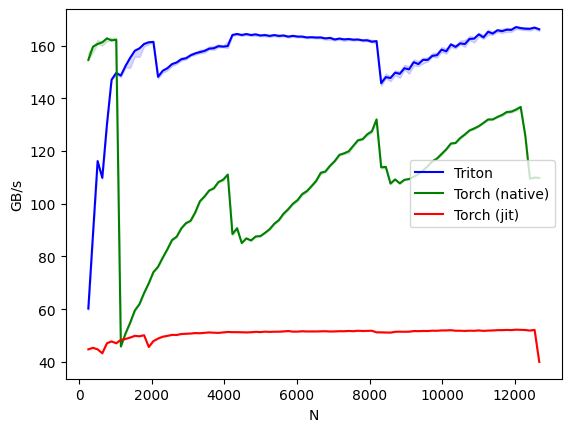

In [7]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=["N"],
        x_vals=[128 * i for i in range(2, 100)],
        line_arg="provider",
        line_vals=["triton", "torch-native", "torch-jit"],
        line_names=["Triton", "Torch (native)", "Torch (jit)"],
        styles=[("blue", "-"), ("green", "-"), ("red", "-")],
        ylabel="GB/s",
        plot_name="softmax-performance",
        args={"M": 4096},
    )
)
def benchmark(M, N, provider):
    x = torch.randn((M, N), device="cuda", dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == "triton":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: softmax(x), quantiles=quantiles
        )
    if provider == "torch-native":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: torch.softmax(x, dim=1), quantiles=quantiles
        )
    if provider == "torch-jit":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: naive_softmax(x), quantiles=quantiles
        )
    gbps = lambda ms: 2 * x.nelement() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)


# Triton大约可以比torch(jit)快4倍左右
benchmark.run(show_plots=True, print_data=False, save_path="")